## Libraries import

In [1]:
library(tidyverse)
library(survival)
library(mice)
library(ggridges)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'stringr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() -

## Data loading

In [2]:
avatar_100 <- read.csv("../../datasets/AIDS/AIDS_base_100times.csv", na.strings = c("NA", "", NA))
categorical <- c("hemo", "homo", "drugs", "karnof", "oprior", "z30", "zprior", "race", "gender", "str2", "strat", "symptom", "treat", "offtrt", "r", "cens", "arms")
avatar_100[categorical] <- lapply(avatar_100[categorical], factor)

In [3]:
head(avatar_100)

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,zprior,preanti,...,cd40,cd420,cd496,r,cd80,cd820,cens,days,arms,iter
,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,...,<int>,<int>,<dbl>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<int>
1,36,70.9300,0,0,0,100,0,0,1,0,...,379,490,524,1,596,695,0,1055,2,0
2,24,59.0705,0,0,0,100,0,1,1,653,...,186,195,NA,0,652,721,0,987,1,0
3,40,77.4000,0,1,0,90,0,1,1,1013,...,318,258,273,1,2164,1493,0,987,2,0
4,39,75.4000,0,1,0,90,0,1,1,933,...,313,351,NA,0,1188,956,0,1099,3,0
5,33,75.5930,0,1,0,100,0,1,1,1092,...,433,409,468,1,703,708,0,1118,0,0
6,41,84.8770,0,1,0,100,0,1,1,1106,...,296,333,413,1,1037,687,0,1153,3,0


In [4]:
res_original <- read.csv("../../datasets/results_df/supplemental_table_aids.csv")
res_original <- subset(res_original, subset = str_detect(X, "Original"))
res_original$arm <- c("arms1", "arms2", "arms3") 
res_original$y <- c(1,2,3)

## Graphical parameters

In [5]:
colors <- read.csv("../../color.csv", stringsAsFactors = FALSE)
rownames(colors) <- colors$type

In [6]:
axis_title_size <- 19
axis_text_size <- 19
legend_text_size <- 19
legend_title_size <- 19

## Survival analysis

In [7]:
defaultW <- getOption("warn")
options(warn = -1)
res_avatar_100 <- data.frame()
for (i in unique(avatar_100$iter)) {
    avatar_temp <- subset(x = avatar_100, subset = (iter == i))
    avatar_imp <- complete(mice(avatar_temp, m = 1, maxit = 50, seed = 500, printFlag = FALSE), 1)
    avatar_temp$cd496 <- avatar_imp$cd496 
    summary_cox <- summary(coxph(Surv(time = days/7, event = cens == 1) ~ arms, data = avatar_temp))
    res_avatar <- data.frame(cbind(summary_cox$coefficients[, c("exp(coef)", "Pr(>|z|)")], summary_cox$conf.int[, c("lower .95", "upper .95")]))
    res_avatar$iter <- i
    res_avatar$arm <- rownames(res_avatar)
    res_avatar_100 <- rbind(res_avatar_100, res_avatar)
}
options(warn = defaultW)

Picking joint bandwidth of 0.0161



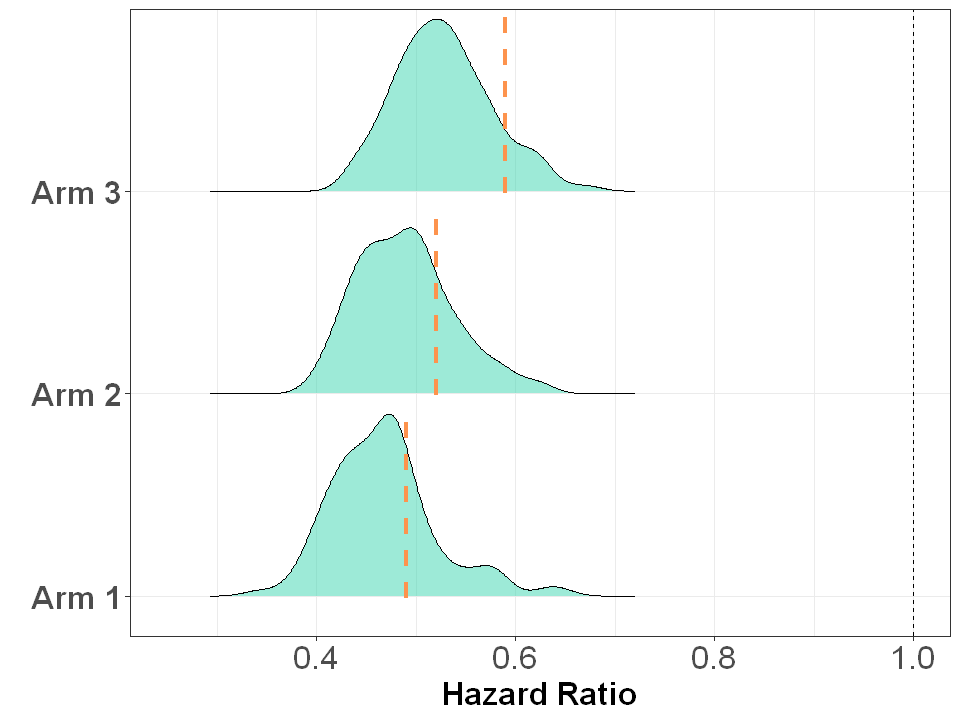

In [8]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() +
    geom_density_ridges(data = res_avatar_100, aes(x = exp.coef., y = arm), scale = 0.9, size = 0.2, fill = colors["avatar", "color"], alpha = 0.5) +
    geom_vline(xintercept = 1, lty = 2) +
    geom_segment(data = res_original, aes(x = Hazard.Ratio, xend = Hazard.Ratio, y = y - 0.01, yend = y + 0.9), col = colors["original", "color"], size = 1.4, lty = 2) +
    theme_bw() +
    ylab("") +
    xlim(c(0.25,1)) +
    xlab("Hazard Ratio") +
    scale_y_discrete(labels = c("Arm 1", "Arm 2", "Arm 3"), expand = expansion(mult = c(0.1, 0.35))) +
    theme(axis.title.x = element_text(size = axis_title_size, face = "bold"),
          axis.text.x = element_text(size = axis_text_size),
          axis.text.y = element_text(color = "gray30", size = axis_text_size, face = "bold"))

Picking joint bandwidth of 0.0161



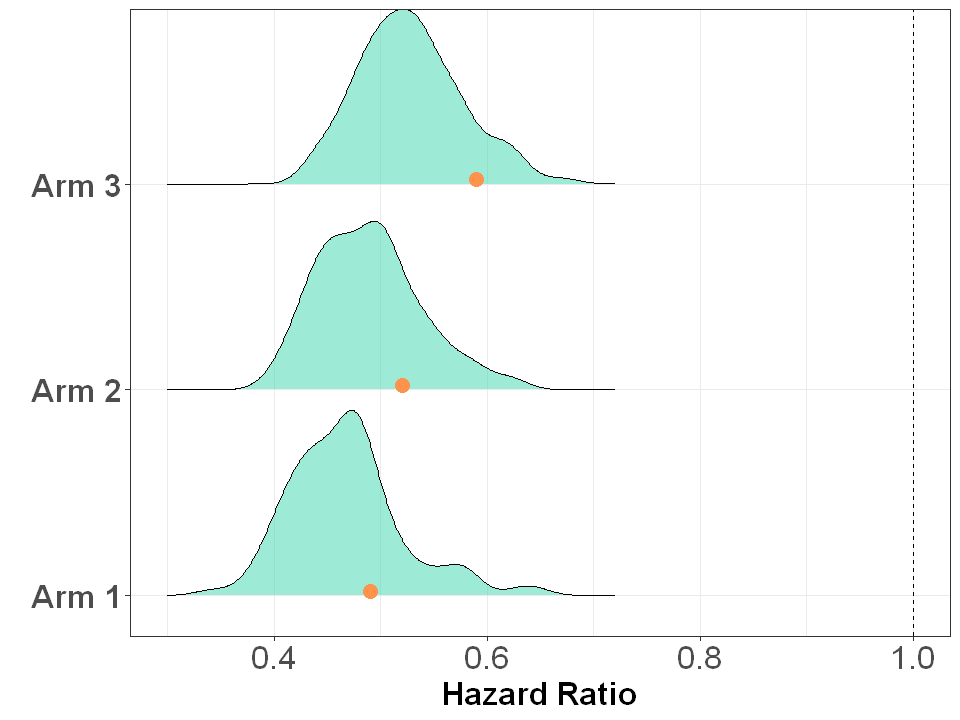

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() +
    geom_density_ridges(data = res_avatar_100, aes(x = exp.coef., y = arm), scale = 0.9, size = 0.2, fill = colors["avatar", "color"], alpha = 0.5) +
    geom_vline(xintercept = 1, lty = 2) +
    geom_point(data = res_original, aes(x = Hazard.Ratio, y = y + 0.02), col = colors["original", "color"], size = 4) +
    theme_bw() +
    ylab("") +
    xlim(c(0.3,1)) +
    xlab("Hazard Ratio") +
    scale_y_discrete(labels = c("Arm 1", "Arm 2", "Arm 3"), expand = expansion(mult = c(0.1, 0.35))) +
    theme(axis.title.x = element_text(size = axis_title_size, face = "bold"),
          axis.text.x = element_text(size = axis_text_size),
          axis.text.y = element_text(color = "gray30", size = axis_text_size, face = "bold"))